### Import libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report

### Import dataset

In [5]:
pd.set_option('display.max_columns',None)

In [6]:
df = pd.read_csv('data.csv')
df

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.000000e+00,0.458143,7.250725e-04,0.000000,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,2.559237e-02,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.000000e+00,0.461867,6.470647e-04,0.000000,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9

# 1.

### check
    1] shape,
    2] features,
    3] types,
    4] target distribution

In [7]:
df.shape

(6819, 96)

In [8]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Interest Rate 

In [9]:
df['Bankrupt?'].value_counts()

Bankrupt?
0    6599
1     220
Name: count, dtype: int64

# 2.

### Exploratory Data Analysis

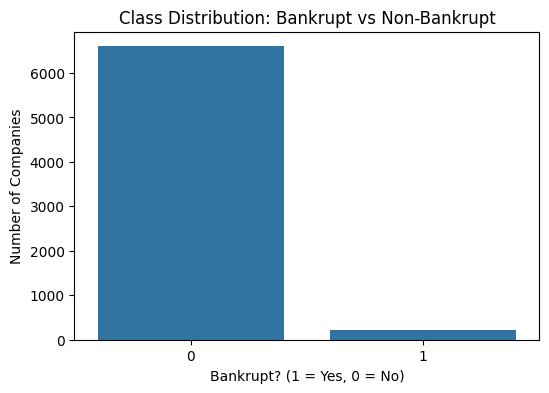

In [10]:
# Class Imbalance 
plt.figure(figsize=(6,4))
sns.countplot(x='Bankrupt?', data=df)
plt.title("Class Distribution: Bankrupt vs Non-Bankrupt")
plt.xlabel("Bankrupt? (1 = Yes, 0 = No)")
plt.ylabel("Number of Companies")
plt.show()

## Class imbalance
<p>The dataset is highly imbalanced, with a very small percentage of bankrupt firms.</p>
<p>This reflects real-world credit data and requires careful model evaluation.</p>

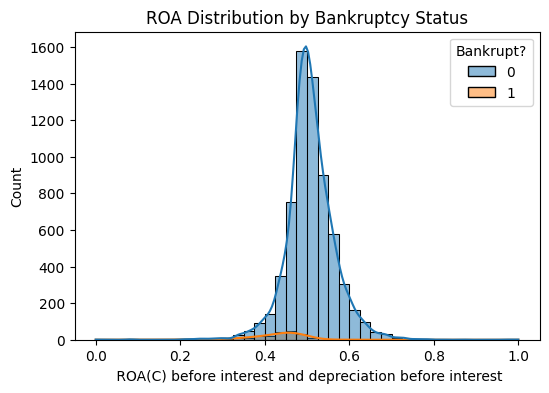

In [11]:
# Distribution of a Key Feature
feature = ' ROA(C) before interest and depreciation before interest'

plt.figure(figsize=(6,4))
sns.histplot(data=df, x=feature, hue='Bankrupt?', bins=40, kde=True)
plt.title("ROA Distribution by Bankruptcy Status")
plt.show()

## Profitability impact
<p>Companies with lower ROA values show higher bankruptcy occurrence.</p>
<p>Profitability appears to be a key indicator of financial health.</p>

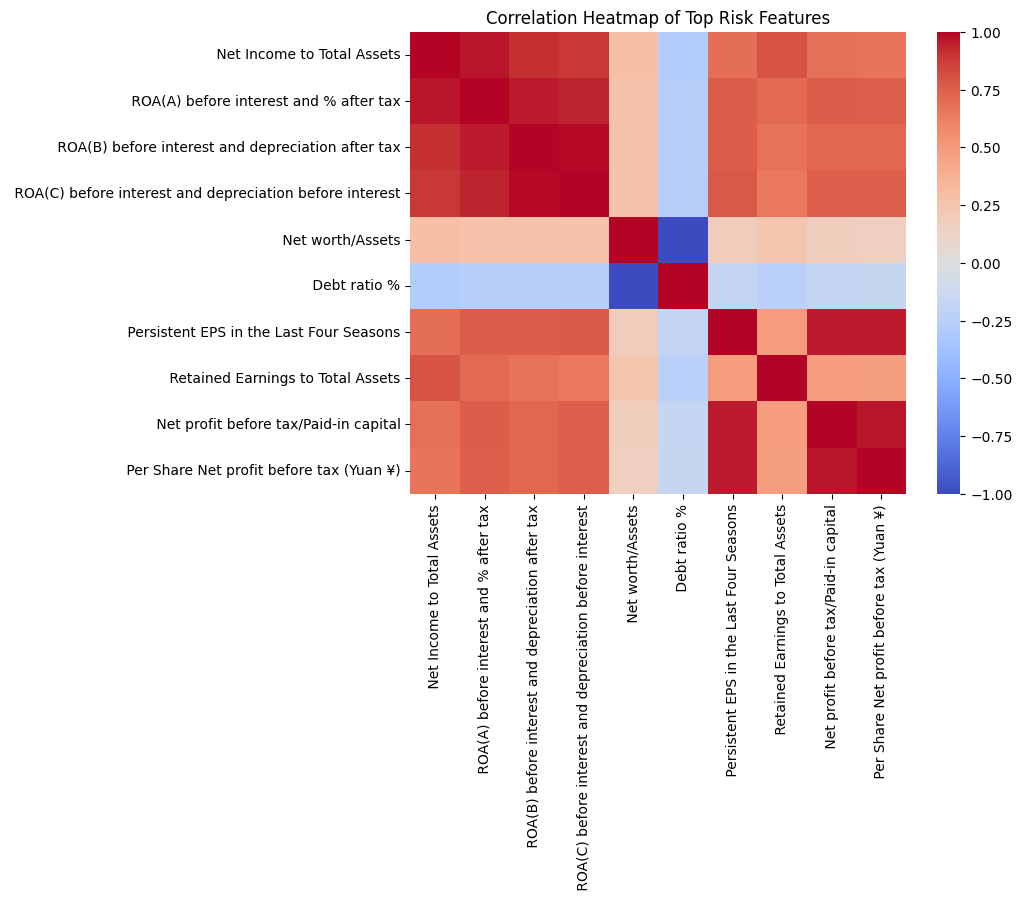

In [12]:
# Correlation Heatmap
corr = df.corr()['Bankrupt?'].abs().sort_values(ascending=False)
top_features = corr.index[1:11]  # top 10 excluding target

plt.figure(figsize=(8,6))
sns.heatmap(df[top_features].corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Top Risk Features")
plt.show()

## Strong correlated financial ratios
<p>1. Several profitability and asset-related ratios show strong correlations.</p>
<p>2. These features are likely to be important drivers in the risk model.</p>

# 3.

<h3>Preprocessing</h3>

In [13]:
logistic_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

<h3>Train Test Split</h3>

In [14]:
X = df.drop('Bankrupt?',axis=1)
y = df['Bankrupt?']

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

## 4. Train Models

### 1. Base Line Model - Logistic Regression (with appropriate preprocessing)

In [16]:
logistic_pipeline.fit(X_train,y_train)

y_pred_LR = logistic_pipeline.predict(X_test)

In [17]:
lr_probs = logistic_pipeline.predict_proba(X_test)[:,1]

lr_roc = roc_auc_score(y_test,lr_probs)
lr_pr = average_precision_score(y_test,lr_probs)


print("Logistic Regression ROC-AUC:",lr_roc)
print("Logistic Regression PR-AUC:",lr_pr)


threshold = 0.20

lr_pred = (lr_probs >= threshold).astype(int)

print('\nLogistic Regression Confusion Matrix')
print(confusion_matrix(y_test, lr_pred))

Logistic Regression ROC-AUC: 0.9171487603305785
Logistic Regression PR-AUC: 0.3189765045643962

Logistic Regression Confusion Matrix
[[971 349]
 [  4  40]]


### Gradient Boosting

In [18]:
GB = GradientBoostingClassifier(random_state=42)


GB.fit(X_train,y_train)

y_pred_GB = GB.predict(X_test)

In [19]:
print(classification_report(y_test,y_pred_GB))
print(confusion_matrix(y_test,y_pred_GB))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1320
           1       0.58      0.34      0.43        44

    accuracy                           0.97      1364
   macro avg       0.78      0.67      0.71      1364
weighted avg       0.97      0.97      0.97      1364

[[1309   11]
 [  29   15]]


In [20]:
gb_probs = GB.predict_proba(X_test)[:,1]

gb_roc = roc_auc_score(y_test,gb_probs)
gb_pr = average_precision_score(y_test,gb_probs)


print("Gradient Boost ROC-AUC:",gb_roc)
print("Gradient Boost PR-AUC:",gb_pr)


threshold = 0.20

gb_pred = (gb_probs >= threshold).astype(int)

print('\nGradient Boost Confusion Matrix')
print(confusion_matrix(y_test, gb_pred))

Gradient Boost ROC-AUC: 0.9532369146005509
Gradient Boost PR-AUC: 0.4609072262320088

Gradient Boost Confusion Matrix
[[1287   33]
 [  14   30]]


### Random Forest

In [21]:
RF = RandomForestClassifier(random_state=42)

RF.fit(X_train,y_train)

y_pred_RF = RF.predict(X_test)

In [22]:
print(classification_report(y_test,y_pred_RF))
print(confusion_matrix(y_test,y_pred_RF))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1320
           1       0.73      0.18      0.29        44

    accuracy                           0.97      1364
   macro avg       0.85      0.59      0.64      1364
weighted avg       0.97      0.97      0.96      1364

[[1317    3]
 [  36    8]]


In [23]:
rf_probs = RF.predict_proba(X_test)[:,1]

rf_roc = roc_auc_score(y_test,rf_probs)
rf_pr = average_precision_score(y_test,rf_probs)


print("Random Forest ROC-AUC:",rf_roc)
print("Random Forest PR-AUC:",rf_pr)


threshold = 0.20

rf_pred = (rf_probs >= threshold).astype(int)

print('\nRandom Forest Confusion Matrix')
print(confusion_matrix(y_test, rf_pred))

Random Forest ROC-AUC: 0.9356318870523416
Random Forest PR-AUC: 0.4526891175893725

Random Forest Confusion Matrix
[[1266   54]
 [  13   31]]


### XGBoost

In [24]:
XG = XGBClassifier(random_state=42, eval_metric='logloss')

XG.fit(X_train,y_train)

y_pred_XG = XG.predict(X_test)

In [25]:
print(classification_report(y_test,y_pred_XG))
print(confusion_matrix(y_test,y_pred_XG))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1320
           1       0.61      0.32      0.42        44

    accuracy                           0.97      1364
   macro avg       0.79      0.66      0.70      1364
weighted avg       0.97      0.97      0.97      1364

[[1311    9]
 [  30   14]]


In [26]:
xg_probs = XG.predict_proba(X_test)[:,1]

xg_roc = roc_auc_score(y_test,xg_probs)
xg_pr = average_precision_score(y_test,xg_probs)


print("XG Boost ROC-AUC:",xg_roc)
print("XG Boost PR-AUC:",xg_pr)


threshold = 0.20

xg_pred = (xg_probs >= threshold).astype(int)

print('\n XG Boost Confusion Matrix')
print(confusion_matrix(y_test, xg_pred))

XG Boost ROC-AUC: 0.9671315426997246
XG Boost PR-AUC: 0.4997923073076926

 XG Boost Confusion Matrix
[[1300   20]
 [  23   21]]


#### Final Model: XGBoost

XGBoost achieved the highest ROC–AUC (0.967) and PR–AUC (0.500).
Therefore, it is selected as the final model for bankruptcy risk prediction.


### Threshold Selection

We selected a probability threshold of 0.20 for classification.

Since bankruptcy events are rare, the business prefers to minimize false negatives (approving risky companies) rather than false positives (rejecting safe companies). A lower threshold helps identify more high-risk firms, reducing expected credit losses.

Therefore, a threshold of 0.20 provides a reasonable trade-off between risk detection and approval rates.

In [27]:
pd_probs = XG.predict_proba(X_test)[:, 1]

risk_df = X_test.copy()
risk_df["pd"] = pd_probs

risk_df.head()


,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,pd
1244,0.503242,0.556149,0.552278,0.609399,0.609399,0.999043,0.797445,0.809349,0.303466,0.781609,1.792366e-04,0.000000e+00,0.464137,0.000677,0.305294,0.174624,0.174624,0.174624,0.221424,0.322416,0.035573,0.108867,0.178203,0.022085,0.848011,0.689259,0.689259,0.217577,6.940000e+09,0.000461,0.263721,0.382475,0.007731,0.005948,0.632256,0.010452,0.157995,0.842005,0.005013,0.377514,0.005366,0.108848,0.177226,0.404004,0.143928,0.000745,0.008497,0.000159,1.293611e-04,0.042258,0.012881,0.395468,0.013122,0.776891,0.348043,0.425024,0.046361,0.006166,0.002393,0.102555,0.345771,0.277450,0.004395,0.613886,0.734249,0.331976,0.009540,0.934622,0.002277,0.035324,1.143104e-04,9.710000e+09,0.593934,3.600000e+09,0.671569,0.571777,0.613886,0.331976,0.119148,0.637692,0.458428,0.590727,0.313521,0.037513,0,0.805667,0.000830,0.623746,0.609399,0.841004,0.282359,0.027273,0.566736,1,0.022839,0.000174
6303,0.485984,0.547754,0.530649,0.598812,0.598812,0.999002,0.797424,0.809331,0.303516,0.781591,5.060000e+08,5.430000e+08,0.468455,0.000478,0.404899,0.197463,0.197463,0.197463,0.220384,0.331718,0.050622,0.104877,0.177902,0.022059,0.847999,0.689180,0.689180,0.217568,6.060000e+09,0.000455,0.263271,0.393242,0.005662,0.005094,0.631828,0.005165,0.106721,0.893279,0.019780,0.374069,0.005850,0.104898,0.176910,0.399768,0.181409,0.000692,0.009132,0.000683,8.012824

In [28]:
def assign_risk_tier(pd):
    if pd < 0.05:
        return "A"
    elif pd < 0.15:
        return "B"
    elif pd < 0.30:
        return "C"
    else:
        return "D"

risk_df["risk_tier"] = risk_df["pd"].apply(assign_risk_tier)

risk_df.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,pd,risk_tier
1244,0.503242,0.556149,0.552278,0.609399,0.609399,0.999043,0.797445,0.809349,0.303466,0.781609,1.792366e-04,0.000000e+00,0.464137,0.000677,0.305294,0.174624,0.174624,0.174624,0.221424,0.322416,0.035573,0.108867,0.178203,0.022085,0.848011,0.689259,0.689259,0.217577,6.940000e+09,0.000461,0.263721,0.382475,0.007731,0.005948,0.632256,0.010452,0.157995,0.842005,0.005013,0.377514,0.005366,0.108848,0.177226,0.404004,0.143928,0.000745,0.008497,0.000159,1.293611e-04,0.042258,0.012881,0.395468,0.013122,0.776891,0.348043,0.425024,0.046361,0.006166,0.002393,0.102555,0.345771,0.277450,0.004395,0.613886,0.734249,0.331976,0.009540,0.934622,0.002277,0.035324,1.143104e-04,9.710000e+09,0.593934,3.600000e+09,0.671569,0.571777,0.613886,0.331976,0.119148,0.637692,0.458428,0.590727,0.313521,0.037513,0,0.805667,0.000830,0.623746,0.609399,0.841004,0.282359,0.027273,0.566736,1,0.022839,0.000174,A
6303,0.485984,0.547754,0.530649,0.598812,0.598812,0.999002,0.797424,0.809331,0.303516,0.781591,5.060000e+08,5.430000e+08,0.468455,0.000478,0.404899,0.197463,0.197463,0.197463,0.220384,0.331718,0.050622,0.104877,0.177902,0.022059,0.847999,0.689180,0.689180,0.217568,6.060000e+09,0.000455,0.263271,0.393242,0.005662,0.005094,0.631828,0.005165,0.106721,0.893279,0.019780,0.374069,0.005850,0.104898,0.176910,0.399768,0.181409,0.000692,0.009132,0.000

In [29]:
importances = XG.feature_importances_
feature_names = X_test.columns

feat_imp = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values(by="importance", ascending=False)
)

top_features = feat_imp.head(3)["feature"].tolist()
top_reason_text = ", ".join(top_features)

risk_df["top_reasons"] = top_reason_text

risk_df.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,pd,risk_tier,top_reasons
1244,0.503242,0.556149,0.552278,0.609399,0.609399,0.999043,0.797445,0.809349,0.303466,0.781609,1.792366e-04,0.000000e+00,0.464137,0.000677,0.305294,0.174624,0.174624,0.174624,0.221424,0.322416,0.035573,0.108867,0.178203,0.022085,0.848011,0.689259,0.689259,0.217577,6.940000e+09,0.000461,0.263721,0.382475,0.007731,0.005948,0.632256,0.010452,0.157995,0.842005,0.005013,0.377514,0.005366,0.108848,0.177226,0.404004,0.143928,0.000745,0.008497,0.000159,1.293611e-04,0.042258,0.012881,0.395468,0.013122,0.776891,0.348043,0.425024,0.046361,0.006166,0.002393,0.102555,0.345771,0.277450,0.004395,0.613886,0.734249,0.331976,0.009540,0.934622,0.002277,0.035324,1.143104e-04,9.710000e+09,0.593934,3.600000e+09,0.671569,0.571777,0.613886,0.331976,0.119148,0.637692,0.458428,0.590727,0.313521,0.037513,0,0.805667,0.000830,0.623746,0.609399,0.841004,0.282359,0.027273,0.566736,1,0.022839,0.000174,A,"Net Income to Stockholder's Equity, Borrowin..."
6303,0.485984,0.547754,0.530649,0.598812,0.598812,0.999002,0.797424,0.809331,0.303516,0.781591,5.060000e+08,5.430000e+08,0.468455,0.000478,0.404899,0.197463,0.197463,0.197463,0.220384,0.331718,0.050622,0.104877,0.177902,0.022059,0.847999,0.689180,0.689180,0.217568,6.060000e+09,0.000455,0.263271,0.393242,0.005662,0.005094,0.631828,0.005165,0.106721,0.893279,0.019780,0.374069,0.0058

In [30]:
risk_profile_sample = risk_df[["pd", "risk_tier", "top_reasons"]].head(5)
risk_profile_sample

,pd,risk_tier,top_reasons
1244,0.000174,A,"Net Income to Stockholder's Equity, Borrowin..."
6303,0.000403,A,"Net Income to Stockholder's Equity, Borrowin..."
4712,0.000012,A,"Net Income to Stockholder's Equity, Borrowin..."
3273,0.000013,A,"Net Income to Stockholder's Equity, Borrowin..."
6430,0.000032,A,"Net Income to Stockholder's Equity, Borrowin..."


In [31]:
EAD = 10000
LGD = 0.60

risk_df["ECL"] = risk_df["pd"] * LGD * EAD

risk_df.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,pd,risk_tier,top_reasons,ECL
1244,0.503242,0.556149,0.552278,0.609399,0.609399,0.999043,0.797445,0.809349,0.303466,0.781609,1.792366e-04,0.000000e+00,0.464137,0.000677,0.305294,0.174624,0.174624,0.174624,0.221424,0.322416,0.035573,0.108867,0.178203,0.022085,0.848011,0.689259,0.689259,0.217577,6.940000e+09,0.000461,0.263721,0.382475,0.007731,0.005948,0.632256,0.010452,0.157995,0.842005,0.005013,0.377514,0.005366,0.108848,0.177226,0.404004,0.143928,0.000745,0.008497,0.000159,1.293611e-04,0.042258,0.012881,0.395468,0.013122,0.776891,0.348043,0.425024,0.046361,0.006166,0.002393,0.102555,0.345771,0.277450,0.004395,0.613886,0.734249,0.331976,0.009540,0.934622,0.002277,0.035324,1.143104e-04,9.710000e+09,0.593934,3.600000e+09,0.671569,0.571777,0.613886,0.331976,0.119148,0.637692,0.458428,0.590727,0.313521,0.037513,0,0.805667,0.000830,0.623746,0.609399,0.841004,0.282359,0.027273,0.566736,1,0.022839,0.000174,A,"Net Income to Stockholder's Equity, Borrowin...",1.041263
6303,0.485984,0.547754,0.530649,0.598812,0.598812,0.999002,0.797424,0.809331,0.303516,0.781591,5.060000e+08,5.430000e+08,0.468455,0.000478,0.404899,0.197463,0.197463,0.197463,0.220384,0.331718,0.050622,0.104877,0.177902,0.022059,0.847999,0.689180,0.689180,0.217568,6.060000e+09,0.000455,0.263271,0.393242,0.005662,0.005094,0.631828,0.005165,0.106721,0.893279,0.019780,0.

In [32]:
approval_threshold = 1200

risk_df["decision"] = risk_df["ECL"].apply(
    lambda x: "Approve" if x < approval_threshold else "Decline"
)

risk_df.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,pd,risk_tier,top_reasons,ECL,decision
1244,0.503242,0.556149,0.552278,0.609399,0.609399,0.999043,0.797445,0.809349,0.303466,0.781609,1.792366e-04,0.000000e+00,0.464137,0.000677,0.305294,0.174624,0.174624,0.174624,0.221424,0.322416,0.035573,0.108867,0.178203,0.022085,0.848011,0.689259,0.689259,0.217577,6.940000e+09,0.000461,0.263721,0.382475,0.007731,0.005948,0.632256,0.010452,0.157995,0.842005,0.005013,0.377514,0.005366,0.108848,0.177226,0.404004,0.143928,0.000745,0.008497,0.000159,1.293611e-04,0.042258,0.012881,0.395468,0.013122,0.776891,0.348043,0.425024,0.046361,0.006166,0.002393,0.102555,0.345771,0.277450,0.004395,0.613886,0.734249,0.331976,0.009540,0.934622,0.002277,0.035324,1.143104e-04,9.710000e+09,0.593934,3.600000e+09,0.671569,0.571777,0.613886,0.331976,0.119148,0.637692,0.458428,0.590727,0.313521,0.037513,0,0.805667,0.000830,0.623746,0.609399,0.841004,0.282359,0.027273,0.566736,1,0.022839,0.000174,A,"Net Income to Stockholder's Equity, Borrowin...",1.041263,Approve
6303,0.485984,0.547754,0.530649,0.598812,0.598812,0.999002,0.797424,0.809331,0.303516,0.781591,5.060000e+08,5.430000e+08,0.468455,0.000478,0.404899,0.197463,0.197463,0.197463,0.220384,0.331718,0.050622,0.104877,0.177902,0.022059,0.847999,0.689180,0.689180,0.217568,6.060000e+09,0.000455,0.263271,0.393242,0.005662,0.005094,0.631828,0.005165,0.106721,0.8

In [33]:
approval_rate = (risk_df["decision"] == "Approve").mean()

approved = risk_df[risk_df["decision"] == "Approve"]

total_expected_loss = approved["ECL"].sum()

expected_defaults = approved["pd"].sum()

print("Approval Rate:", round(approval_rate, 3))
print("Total Expected Loss:", round(total_expected_loss, 2))
print("Expected Defaults:", round(expected_defaults, 2))

Approval Rate: 0.97
Total Expected Loss: 25195.56
Expected Defaults: 4.2


### Decision Policy

We use an Expected Credit Loss (ECL) based approval rule.

Assumptions:
- Exposure at Default (EAD) = $10,000
- Loss Given Default (LGD) = 60%
- ECL = PD × LGD × EAD

Decision rule:
- Approve if ECL < $1,200
- Decline otherwise

This policy ensures that the expected loss per approved company remains within a conservative risk tolerance, helping protect the lending portfolio.

## Bonus: Additional Data for Real SME Risk Modeling
In a real-world small and medium enterprise (SME) credit risk model, additional data sources would significantly improve prediction accuracy:

#### Bank transaction data
- Monthly inflow and outflow patterns to assess cash flow stability.


#### Historical loan repayment behavior
- Past defaults, delinquencies, and restructuring events.


#### Credit bureau data
- External credit scores and outstanding obligations.

#### Macroeconomic indicators
- Interest rates, inflation, GDP growth, and sector-specific trends.

#### Industry risk metrics
- Default rates by industry or sector.


#### Director and management history
- Previous bankruptcies, legal issues, or failed ventures.


#### Tax filings and GST data
- Revenue consistency and compliance behavior.


#### Accounts receivable aging
- Payment delays from customers indicating liquidity stress.


#### Collateral and asset quality
- Type, liquidity, and value stability of pledged assets.


#### Supplier and customer concentration
- Dependence on a few clients or vendors increases risk.